In [ ]:
#@title
import pandas as pd
import numpy as np
import nltk
import future
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.naive_bayes import BernoulliNB, MultinomialNB
from sklearn import metrics
from sklearn.metrics import roc_auc_score, accuracy_score
from sklearn.preprocessing import label_binarize
from sklearn.linear_model import LogisticRegression

from sklearn.pipeline import Pipeline
from sklearn import svm
from sklearn.svm import LinearSVC
from sklearn.svm import SVR
from sklearn import metrics

from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier

from bs4 import BeautifulSoup
import re
import nltk
from nltk.corpus import stopwords

In [ ]:
import pandas as pd

df = pd.read_csv('/Amazon_Unlocked_Mobile.csv', encoding='ISO-8859-1')
df.head()


,Product Name,Brand Name,Price,Rating,Reviews,Review Votes
0,"""CLEAR CLEAN ESN"" Sprint EPIC 4G Galaxy SPH-D7...",Samsung,199.99,5,I feel so LUCKY to have found this used (phone...,1.0
1,"""CLEAR CLEAN ESN"" Sprint EPIC 4G Galaxy SPH-D7...",Samsung,199.99,4,"nice phone, nice up grade from my pantach revu...",0.0
2,"""CLEAR CLEAN ESN"" Sprint EPIC 4G Galaxy SPH-D7...",Samsung,199.99,5,Very pleased,0.0
3,"""CLEAR CLEAN ESN"" Sprint EPIC 4G Galaxy SPH-D7...",Samsung,199.99,4,It works good but it goes slow sometimes but i...,0.0
4,"""CLEAR CLEAN ESN"" Sprint EPIC 4G Galaxy SPH-D7...",Samsung,199.99,4,Great phone to replace my lost phone. The only...,0.0


In [ ]:
print("Summary statistics of numerical features : \n", df.describe())
print("\nTotal number of brands: ", len(list(set(df['Brand Name']))))
print("\nTotal number of unique products: ", len(list(set(df['Product Name']))))


Summary statistics of numerical features : 
                Price         Rating   Review Votes
count  407907.000000  413840.000000  401544.000000
mean      226.867155       3.819578       1.507237
std       273.006259       1.548216       9.163853
min         1.730000       1.000000       0.000000
25%        79.990000       3.000000       0.000000
50%       144.710000       5.000000       0.000000
75%       269.990000       5.000000       1.000000
max      2598.000000       5.000000     645.000000

Total number of brands:  385

Total number of unique products:  4410


Text(0.5, 1.0, 'Number of Reviews for Top 20 Brands')

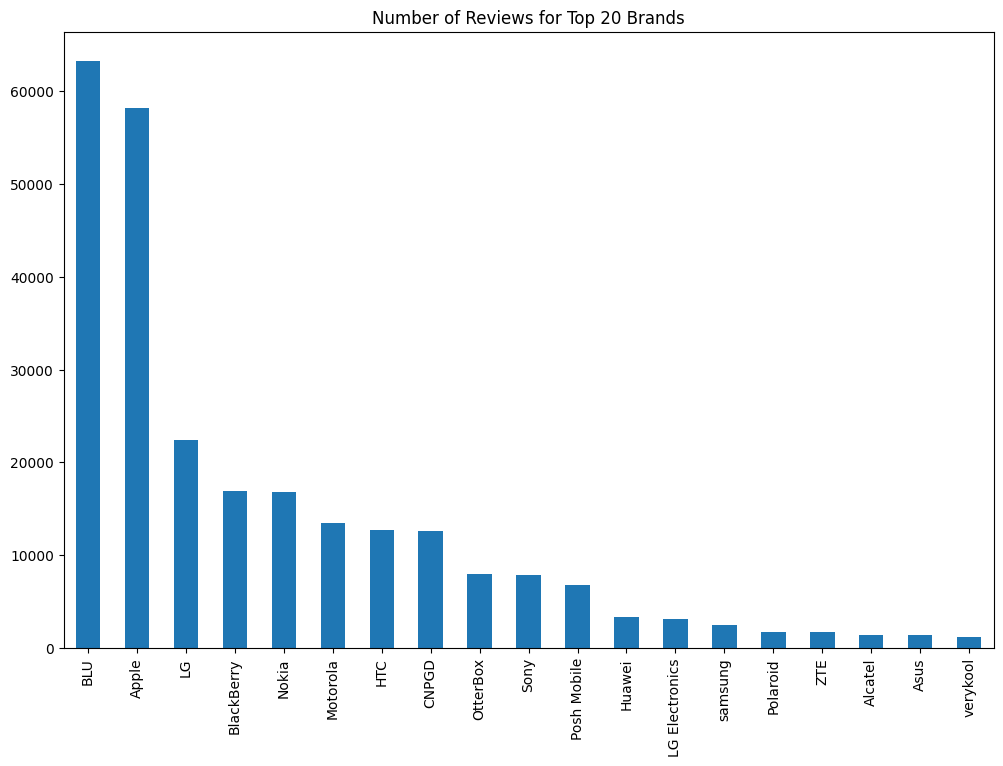

In [ ]:
# Plot number of reviews for top 20 brands
brands = df["Brand Name"].value_counts()
# brands.count()
plt.figure(figsize=(12,8))
brands[1:20].plot(kind='bar')
plt.title("Number of Reviews for Top 20 Brands")

In [ ]:
# Drop missing value and unnamed columns
# Drop missing value and unnamed columns
res = df.dropna(axis=1, how='all')
#res = res.loc[:, ~res.columns.str.contains('^Unnamed')]

# Create labels based on Rating column
labels = []
for cell in res['Rating']:
    if str(cell) >= str('4'):
        labels.append('2')  # Good
    elif str(cell) == str('3'):
        labels.append('1')  # Neutral
    else:
        labels.append('0')  # Poor

# Add Label column and remove Review Votes and Rating columns
res['Label'] = labels
res.drop(['Review Votes', 'Rating'], axis=1, inplace=True)

res.head()

,Product Name,Brand Name,Price,Reviews,Label
0,"""CLEAR CLEAN ESN"" Sprint EPIC 4G Galaxy SPH-D7...",Samsung,199.99,I feel so LUCKY to have found this used (phone...,2
1,"""CLEAR CLEAN ESN"" Sprint EPIC 4G Galaxy SPH-D7...",Samsung,199.99,"nice phone, nice up grade from my pantach revu...",2
2,"""CLEAR CLEAN ESN"" Sprint EPIC 4G Galaxy SPH-D7...",Samsung,199.99,Very pleased,2
3,"""CLEAR CLEAN ESN"" Sprint EPIC 4G Galaxy SPH-D7...",Samsung,199.99,It works good but it goes slow sometimes but i...,2
4,"""CLEAR CLEAN ESN"" Sprint EPIC 4G Galaxy SPH-D7...",Samsung,199.99,Great phone to replace my lost phone. The only...,2


In [ ]:
from sklearn.model_selection import train_test_split
# Split data into training set and validation
X_train, X_test, y_train, y_test = train_test_split(res['Reviews'], res['Label'], \
                                                    test_size=0.1, random_state=0)

print('Load %d training examples and %d validation examples. \n' %(X_train.shape[0],X_test.shape[0]))
print('Show a review in the training set : \n', X_train.iloc[45])

Load 372456 training examples and 41384 validation examples. 

Show a review in the training set : 
 Excellent


In [ ]:
import math
import re

def cleanText(raw_text, remove_stopwords=False, stemming=False, split_text=False):
    '''
    Convert a raw review to a cleaned review
    '''
    if isinstance(raw_text, float) and math.isnan(raw_text): # handle NaN values
        return ""

    text = BeautifulSoup(raw_text, 'lxml').get_text()  #remove html
    letters_only = re.sub("[^a-zA-Z]", " ", text)  # remove non-character
    words = letters_only.lower().split() # convert to lower case

    if remove_stopwords: # remove stopword
        stops = set(stopwords.words("english"))
        words = [w for w in words if not w in stops]

    if stemming==True: # stemming
#         stemmer = PorterStemmer()
        stemmer = SnowballStemmer('english')
        words = [stemmer.stem(w) for w in words]

    if split_text==True:  # split text
        return words

    return " ".join(words)

In [ ]:
# Preprocess text data in training set and validation set
X_train_cleaned = []
X_test_cleaned = []

for d in X_train:
    X_train_cleaned.append(cleanText(d))
print('Show a cleaned review in the training set : \n',  X_train_cleaned[55])

for d in X_test:
    X_test_cleaned.append(cleanText(d))

<ipython-input-46-f8d68d18ab62>:11: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  text = BeautifulSoup(raw_text, 'lxml').get_text()  #remove html
<ipython-input-46-f8d68d18ab62>:11: MarkupResemblesLocatorWarning: The input looks more like a URL than markup. You may want to use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  text = BeautifulSoup(raw_text, 'lxml').get_text()  #remove html


Show a cleaned review in the training set : 
 great phone for the price very satisfied the power button is very sensitive and takes some getting used to resolution is great very high quality camera is excellent best i ve had comparing against samsung galaxy note and a zte fingerprint scan is very reliable as long as you re not a welder like me yes one cut or or burn will throw it off program it to different fingers only real downfall so far is my screen has broken from only a two foot fall with the factory protective jell case best to get an otterbox case or something much tougher


CountVectorizer with Mulinomial Naive Bayes (Benchmark Model)

we first create a CountVectorizer object and transform the training data using the fit_transform() method. We then train a MultinomialNB classifier on the transformed training data.

Next, we transform the test data using the same vectorizer object using the transform() method. We then predict the labels for the test data using the trained MultinomialNB classifier and calculate the accuracy score using the accuracy_score() function from scikit-learn's metrics module.

After that, we calculate the confusion matrix using the confusion_matrix() function and print it.



**bold text**

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_auc_score
# Create CountVectorizer object and transform the training data
vectorizer = CountVectorizer()
X_train = vectorizer.fit_transform(X_train_cleaned)
print("Number of features : %d \n" % len(vectorizer.vocabulary_))
print("Show some feature names : \n", list(vectorizer.vocabulary_.keys())[::1000])

# Train the model
mnb = MultinomialNB()
mnb.fit(X_train, y_train)

# Transform the test data using the same vectorizer
X_test = vectorizer.transform(X_test_cleaned)

# Predict the labels for the test data
y_pred = mnb.predict(X_test)

# Calculate the accuracy score of the model
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

# Calculate the confusion matrix
cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(cm)

Number of features : 58555 

Show some feature names : 
 ['the', 'rendered', 'mention', 'observations', 'prepay', 'permanently', 'unlockedneutral', 'bags', 'snugly', 'mods', 'stafa', 'kingo', 'speakerscons', 'brain', 'beczus', 'pd', 'ird', 'qualifies', 'carte', 'returend', 'usmodel', 'factbe', 'lessconcerns', 'tecnoship', 'suffices', 'adores', 'atbat', 'choosefor', 'phond', 'sellig', 'exstatic', 'cuss', 'comed', 'bench', 'spreaker', 'riots', 'characterizes', 'arvelo', 'hunters', 'ofrec', 'lexwwos', 'egsm', 'uped', 'expansions', 'experi', 'resolutionmore', 'bieni', 'awoseme', 'coolmusic', 'shrunk', 'irresponsiblenot', 'cero', 'pricingthis', 'weekswon', 'jetaudio', 'countinously', 'protested', 'skepticals', 'diodes']
Accuracy: 0.8541706939880147
Confusion Matrix:
[[ 7977   467  1455]
 [  978   809  1463]
 [ 1080   592 26563]]


CounterVectorization with Logistic Regression
Some words might frequently appear but have little meaningful information about the sentiment of a particular review.


# New Section

In the code, we first import the necessary packages such as CountVectorizer for vectorizing the text data, LogisticRegression for training a logistic regression model, and accuracy_score and confusion_matrix for evaluating the performance of the model.

We then create an instance of the CountVectorizer class with a min_df parameter of 5, which specifies that we only want to consider terms that occur in at least 5 documents.

Next, we fit the vectorizer to the training data using the fit_transform method to create a sparse matrix of term frequency counts for each document in the training set. We also use the transform method to convert the test data into a similar matrix.

We then create an instance of the LogisticRegression class and fit it to the training data using the fit method.

Finally, we make predictions on the test set using the predict method and calculate the accuracy of the model using the accuracy_score function. We also compute the confusion matrix using the confusion_matrix function to evaluate the performance of the model in more detail.



**bold text**

In [ ]:
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix

# Convert input data to string
X_train_str = np.array([str(text) for text in X_train])
X_test_str = np.array([str(text) for text in X_test])

# Vectorize the text using CountVectorizer
vectorizer = CountVectorizer(min_df=5)
X_train_vectorized = vectorizer.fit_transform(X_train_str)
X_test_vectorized = vectorizer.transform(X_test_str)

# Print number of features
print("Number of features : %d \n" % len(vectorizer.vocabulary_))
# Train a logistic regression model
lr = LogisticRegression()
lr.fit(X_train_vectorized, y_train)
# Make predictions on the test set and calculate accuracy
y_pred = lr.predict(X_test_vectorized)
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

# Calculate confusion matrix
cm = confusion_matrix(y_test, y_pred)
print("Confusion matrix:\n", cm)

Number of features : 21203 



/usr/local/lib/python3.9/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Accuracy: 0.8688140344094336
Confusion matrix:
 [[ 8321   323  1255]
 [  994   761  1495]
 [  916   446 26873]]


system will use two algorithms SVM and Random Forest to perform analysis and to determine which suits better for recommendation.

Support Vector Machine
Here we implement multi-svm for sentiment analysis.
Tip 1 : Here, different kernels can be tried out. For example, linear, nonlinear, precomputed, rbf etc.
Tip 2 : The parameter values given below can be tweaked to obtain different results.
Using LinearSVC
Here you can tweak the api parameters of LinearSVC as per your choice.



In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import LinearSVC
from sklearn import metrics

# Initialize TfidfVectorizer
tfidf = TfidfVectorizer()

# Fit the vectorizer on the training data
x_train_input = tfidf.fit_transform(X_train_cleaned)

# Train a LinearSVC model
svr_lin = LinearSVC(multi_class='ovr',C=1.0,loss='squared_hinge', dual=False)
svr_lin.fit(x_train_input, y_train)

# Make predictions on the test set
y_svr_lin_predicted = svr_lin.predict(tfidf.transform(X_test_cleaned))

# Evaluate the model
print("Accuracy of this SVM = " + str(metrics.accuracy_score(y_test, y_svr_lin_predicted)))
print("Fscore of this SVM = " + str(metrics.precision_recall_fscore_support(y_test, y_svr_lin_predicted, pos_label=2, average='weighted')))
print("F-1 score of this SVM = " + str(metrics.f1_score(y_test, y_svr_lin_predicted, pos_label=2, average='weighted')))
print("confusion matrix = " + str(metrics.confusion_matrix(y_test, y_svr_lin_predicted)))

Accuracy of this SVM = 0.9561365600691444
Fscore of this SVM = (0.9560745861474521, 0.9561365600691444, 0.9561014737406478, None)
F-1 score of this SVM = 0.9561014737406478
confusion matrix = [[1383  106]
 [  97 3042]]


/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1396: UserWarning: Note that pos_label (set to 2) is ignored when average != 'binary' (got 'weighted'). You may use labels=[pos_label] to specify a single positive class.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1396: UserWarning: Note that pos_label (set to 2) is ignored when average != 'binary' (got 'weighted'). You may use labels=[pos_label] to specify a single positive class.
  warnings.warn(


Decision Tree

The first few lines of the code are used for training a Decision Tree Classifier model on a dataset. The data is split into training and testing sets using the train_test_split function from the sklearn library.

The next line of code uses the trained model to make predictions on the test data.

The function modelEvaluation is defined next. This function takes two arguments: the predicted labels and the true labels. It then calculates four metrics: accuracy, precision, recall, and F1-score, using functions from the sklearn library. These metrics are printed to the console.

Finally, the modelEvaluation function is called with the predicted and true labels as arguments.



In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn import metrics

decTree = DecisionTreeClassifier()
decTree.fit(x_train_input, y_train)
y_decTree_predicted = decTree.predict(tfidf.transform(X_test_cleaned))
def modelEvaluation(y_predicted, y_true):
    accuracy = metrics.accuracy_score(y_true, y_predicted)
    precision = metrics.precision_score(y_true, y_predicted, average='weighted')
    recall = metrics.recall_score(y_true, y_predicted, average='weighted')
    f1_score = metrics.f1_score(y_true, y_predicted, average='weighted')
    print("Accuracy: {:.4f}".format(accuracy))
    print("Precision: {:.4f}".format(precision))
    print("Recall: {:.4f}".format(recall))
    print("F1-score: {:.4f}".format(f1_score))

modelEvaluation(y_decTree_predicted, y_test)
print("Accuracy of Decision Tree = {:.4f}".format(decTree.score(tfidf.transform(X_test_cleaned), y_test)))
print("Fscore of this SVM = " + str(metrics.precision_recall_fscore_support(y_test, y_decTree_predicted, pos_label=2, average='weighted')))
print("F-1 score of this SVM = " + str(metrics.f1_score(y_test, y_decTree_predicted, pos_label=2, average='weighted')))
print("confusion matrix = " + str(metrics.confusion_matrix(y_test, y_decTree_predicted)))

Accuracy: 0.9299
Precision: 0.9288
Recall: 0.9299
F1-score: 0.9292
Accuracy of Decision Tree = 0.9299


/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1396: UserWarning: Note that pos_label (set to 2) is ignored when average != 'binary' (got 'weighted'). You may use labels=[pos_label] to specify a single positive class.
  warnings.warn(


Fscore of this SVM = (0.9287667003909064, 0.929924608544365, 0.9292194357457486, None)


/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1396: UserWarning: Note that pos_label (set to 2) is ignored when average != 'binary' (got 'weighted'). You may use labels=[pos_label] to specify a single positive class.
  warnings.warn(


F-1 score of this SVM = 0.9292194357457486
confusion matrix = [[ 8862   312   725]
 [  339  2346   565]
 [  625   334 27276]]


In [ ]:
import joblib
file=open("Amazon_Sentimental_Analysis(1).joblib",'wb')
joblib.dump(svr_lin,file)

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
import joblib

# Initialize TfidfVectorizer
tfidf = TfidfVectorizer()

# Fit the vectorizer on the training data
x_train_input = tfidf.fit_transform(X_train_cleaned)

# Save the vectorizer object
joblib.dump(tfidf, 'tfidf_vectorizer(1).joblib')


['tfidf_vectorizer(1).joblib']

In [ ]:
import joblib
file=open("Amazon_Sentimental_Analysis(2).joblib",'wb')
joblib.dump(decTree,file)

In [ ]:
import pickle
file=open("Amazon_Sentimental_Analysis(3).pkl",'wb')
pickle.dump(svr_lin,file)

In [ ]:
import os
os.getcwd()
